# Machine Learning LAB 2: Perceptrons

Course 2024/25: *F. Chiariotti*

The notebook contains a simple learning task over which we will implement **PERCEPTRON**.

Complete all the **required code sections** and **answer all the questions**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## Classification of Stayed/Churned Customers

The Customer Churn table contains information on all 3,758 customers from a Telecommunications company in California in Q2 2022. Companies are naturally interested in churn, i.e., in which users are likely to switch to another company soon to get a better deal, and which are more loyal customers.

The dataset contains three features:
- **Tenure in Months**: Number of months the customer has stayed with the company
- **Monthly Charge**: The amount charged to the customer monthly
- **Age**: Customer's age

The aim of the task is to predict if a customer will churn or not based on the three features.

---

## Import all the necessary Python libraries and load the dataset

### The Dataset
The dataset is a `.csv` file containing three input features and a label. Here is an example of the first 4 rows of the dataset: 

<center>

Tenure in Months | Monthly Charge | Age | Customer Status |
| -----------------| ---------------|-----|-----------------|
| 9 | 65.6 | 37 | 0 |
| 9 | -4.0 | 46 | 0 |
| 4 | 73.9 | 50 | 1 |
| ... | ... | ... | ... |

</center>

Customer Status is 0 if the customer has stayed with the company and 1 if the customer has churned.

In [71]:
import numpy as np
import numpy.random as npr
import random as rnd
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split

In [78]:
npr.seed(1)

def load_dataset(filename):
    data_train = pd.read_csv(filename)
    #permute the data per Evita problemi in algoritmi sequenziali (come il perceptron))
    data_train = data_train.sample(frac=1).reset_index(drop=True) # shuffle the data
    X = data_train.iloc[:, 0:3].values    # Get first three columns as the input
    Y = data_train.iloc[:, 3].values      # Get the third column as the label
    Y = 2*Y-1                             # Make sure labels are -1 or 1 (0 --> -1, 1 --> 1)
    return X,Y

# Load the dataset
X, Y = load_dataset('data/telecom_customer_churn_cleaned.csv')
print(type(X))
print(type(Y))
print(X.shape)
print(Y.shape)
print(X)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(3757, 3)
(3757,)
[[20.   19.7  62.  ]
 [ 8.   81.25 66.  ]
 [11.   48.55 43.  ]
 ...
 [19.   24.9  20.  ]
 [64.   47.85 61.  ]
 [37.   90.6  42.  ]]


We are going to differentiate (classify) between **class "1" (churned)** and **class "-1" (stayed)**

## Divide the data into training and test sets

In [91]:
# Compute the splits (75% training, 25% test set)
m_training = int(0.75*X.shape[0])
m_test =  X.shape[0] - m_training # m_test is the number of samples in the test set (total-training)
X_training =  X[:m_training]
Y_training =  Y[:m_training]
X_test =   X[m_training:]
Y_test =  Y[m_training:]

print("Number of samples in the train set:", X_training.shape[0])
print("Number of samples in the test set:", X_test.shape[0])
print("Number of churned users in test:", np.sum(Y_test==-1))
print("Number of loyal users in test:", np.sum(Y_test==1))

# Standardize the input matrix (mean 0, variance 1)
# The transformation is computed on training data and then used on all the 3 sets and also in test set!!!
scaler = preprocessing.StandardScaler().fit(X_training) 
np.set_printoptions(suppress=True) # sets to zero floating point numbers < min_float_eps
# we scale X_training:
X_training =  scaler.transform(X_training)      
print ("Mean of the training input data:", X_training.mean(axis=0))
print ("Std of the training input data:",X_training.std(axis=0))
# we scale X_test with the same parameters found with X_training 
# (so the mean and dev will not be exactly 0 and 1 but at least the test set will remain untouched)
X_test =  scaler.transform(X_test)              
print ("Mean of the test input data:", X_test.mean(axis=0))
print ("Std of the test input data:", X_test.std(axis=0))

Number of samples in the train set: 2817
Number of samples in the test set: 940
Number of churned users in test: 479
Number of loyal users in test: 461
Mean of the training input data: [-0.  0. -0.]
Std of the training input data: [1. 1. 1.]
Mean of the test input data: [0.0575483  0.05550169 0.0073833 ]
Std of the test input data: [0.98593187 0.97629659 1.00427583]


We will use **homogeneous coordinates** to describe all the coefficients of the model.

_Hint:_ The conversion can be performed with the function $hstack$ in $numpy$.

In [92]:
def to_homogeneous(X_training, X_test):
    # Transform the input into homogeneous coordinates: we add a column of 1's as first column
    Xh_training = np.hstack( [np.ones( ( X_training.shape[0], 1 ) ), X_training] )
    Xh_test = np.hstack(     [np.ones( ( X_test.shape[0],      1) ), X_test    ] )
    return Xh_training, Xh_test

In [98]:
# convert to homogeneous coordinates using the function above
X_training, X_test = to_homogeneous(X_training, X_test)
print("Training set in homogeneous coordinates:")

In [102]:
print(X_training[:10])

[[ 1.         -0.3798618  -1.57020044  0.85174963]
 [ 1.         -0.87925308  0.47180292  1.08667766]
 [ 1.         -0.75440526 -0.6130632  -0.26415851]
 [ 1.         -1.12894873  0.09856916 -0.96894261]
 [ 1.         -1.12894873 -0.58486332 -1.20387064]
 [ 1.          1.78416712  1.39908145  0.08823353]
 [ 1.         -0.7960212  -1.0990965  -0.32289052]
 [ 1.          0.20276137 -0.39907585 -0.96894261]
 [ 1.         -0.62955744  0.63934341  0.96921364]
 [ 1.         -0.87925308  1.13201197 -0.02923048]]


## Deterministic perceptron

Now **complete** the function *perceptron*. <br>
The **perceptron** algorithm **does not terminate** if the **data** is not **linearly separable**, therefore your implementation should **terminate** if it **reached the termination** condition seen in class **or** if a **maximum number of iterations** have already been run, where one **iteration** corresponds to **one update of the perceptron weights**. In case the **termination** is reached **because** the **maximum** number of **iterations** have been completed, the implementation should **return the best model** seen throughout.

The current version of the perceptron is **deterministic**: we use a fixed rule to decide which sample should be considered (e.g., the one with the lowest index).

The input parameters to pass are:
- $X$: the matrix of input features, one row for each sample
- $Y$: the vector of labels for the input features matrix X
- $max\_num\_iterations$: the maximum number of iterations for running the perceptron

The output values are:
- $best\_w$: the vector with the coefficients of the best model (or the latest, if the termination condition is reached)
- $best\_error$: the *fraction* of misclassified samples for the best model

**Watch out the difference of views and copies!!!!**

In [112]:
def count_errors(current_w, X, Y):
    # This function:
    # -computes the number of misclassified samples
    # -returns the indexes of all misclassified samples
    # -if there are no misclassified samples, returns -1 as index
    n=0          # error count iterator
    idx_miss=[]  # list of missclassified points
    for i in range(len(X)):
        classif = np.dot(current_w, X[i,:])*Y[i]    # problem of this formula and initial weights: in the first try it gives usa 0
        if classif <= 0: 
            n+=1
            idx_miss.append(i)
    if n==0: return 0, -1
    else: return n, idx_miss

    
def perceptron_fixed_update(current_w, X, Y):
    # Write the perceptron update function
    n, idx_miss = count_errors(current_w, X, Y)
    if n > 0 :  new_w = current_w + X[ idx_miss[0],: ] * Y[ idx_miss[0] ]
    else:       new_w = current_w
    return new_w

# version of perceptron function in deterministic case:
def perceptron_no_randomization(X, Y, max_num_iterations):  
    # Write the perceptron main loop:
    current_w = np.zeros( X.shape[1] )
    n, idx_miss = count_errors(current_w, X, Y)
    #print(n)
    # The perceptron should run for up to max_num_iterations, or stop if it finds a solution with ERM=0:
    best_error= n/X.shape[0] 
    best_w = current_w.copy()
    i_iter=0
    while ( n > 0 and  i_iter < max_num_iterations):
        current_w = perceptron_fixed_update(current_w, X, Y)    # update w
        n, idx_miss = count_errors(current_w, X, Y)              # check error of update
        error = n/X.shape[0]                                     # fraction of errors over total points
        if (best_error > error):
            best_error = error
            best_w = current_w.copy()
        i_iter += 1
    return best_w, best_error

Now we use the implementation above of the perceptron to learn a model from the training data using 30 iterations and print the error of the best model we have found.

In [114]:
w_found, error = perceptron_no_randomization(X_training,Y_training, 30)
print(f"Training Error of perceptron (30 iterations):  {error} and the weights are: \n {w_found}")
w_found2, error2 = perceptron_no_randomization(X_training,Y_training, 100)
print(f"Training Error of perceptron (100 iterations):  {error2} and the weights are: \n {w_found2}")

Training Error of perceptron (30 iterations):  0.2751153709620163 and the weights are: 
 [-1.         -3.57365256  1.24507237 -0.67555361]
Training Error of perceptron (100 iterations):  0.2751153709620163 and the weights are: 
 [-1.         -3.57365256  1.24507237 -0.67555361]


Now use the best model $w\_found$ to **predict the labels for the test dataset** and print the fraction of misclassified samples in the test set (the test error that is an estimate of the true loss).

In [116]:
def loss_estimate(w,X,Y):
    # Estimate the test loss:
    t_loss_estimate, idx_miss = count_errors(w, X, Y)
    t_loss_estimate /= X.shape[0]
    return t_loss_estimate

# Error rate on the test set:
true_loss_estimate =   loss_estimate(w_found, X_test, Y_test)       
true_loss_estimate2 =  loss_estimate(w_found2, X_test, Y_test) 

print(f"Test Error of perceptron (30 iterations):   {true_loss_estimate}")
print(f"Test Error of perceptron (100 iterations):  {true_loss_estimate2}")

Test Error of perceptron (30 iterations):   0.26382978723404255
Test Error of perceptron (100 iterations):  0.26382978723404255


### Randomized perceptron

Implement the correct randomized version of the perceptron such that at each iteration the algorithm picks a random misclassified sample and updates the weights using that sample. The functions will be very similar, except for some minor details.

In [118]:
def perceptron_randomized_update(current_w, X, Y):
    n, idx_miss = count_errors(current_w, X, Y)
    # PARTE AGGIORNATA RISPETTO A PRIMA (we need [0] because 'npr.choice' gives us an array)
    rand_index = npr.choice(idx_miss, 1)[0]     
    if n > 0 :  new_w = current_w + X[ rand_index,: ] * Y[ rand_index ]
    else:       new_w = current_w
    return new_w

def perceptron_with_randomization(X, Y, max_num_iterations):  
    current_w = np.zeros( X.shape[1] )
    n, idx_miss = count_errors(current_w, X, Y)
    best_error= n/X.shape[0] 
    best_w = current_w.copy()
    i_iter=0
    while ( n > 0 and  i_iter < max_num_iterations):
        current_w = perceptron_randomized_update(current_w, X, Y)    # PARTE AGGIORNATA RISPETTO A PRIMA
        n, idx_miss = count_errors(current_w, X, Y)                  
        error = n/X.shape[0]                                         
        if (best_error > error):
            best_error = error
            best_w = current_w.copy()
        i_iter += 1
    return best_w, best_error

Now test the correct version of the perceptron using 30 iterations and print the error of the best model we have found.

In [119]:
# Now run the perceptron for 30 iterations
w_found, error = perceptron_with_randomization(X_training, Y_training, 30)
w_found2, error2 = perceptron_with_randomization(X_training, Y_training, 100)
print("Training Error of perceptron (30 iterations): " + str(error))
print("Training Error of perceptron (100 iterations): " + str(error2))

true_loss_estimate =  loss_estimate(w_found, X_test, Y_test)       # Error rate on the test set
true_loss_estimate2 =  loss_estimate(w_found2, X_test, Y_test) 

print("Test Error of perceptron (30 iterations): " + str(true_loss_estimate))
print("Test Error of perceptron (100 iterations): " + str(true_loss_estimate2))

Training Error of perceptron (30 iterations): 0.25097621583244584
Training Error of perceptron (100 iterations): 0.24565140220092296
Test Error of perceptron (30 iterations): 0.251063829787234
Test Error of perceptron (100 iterations): 0.2478723404255319


In [130]:
# Plot the loss with respect to the number of iterations (up to 1000)

losses_rand = []
losses_no_rand = []
num_iterations = []
for i in range(1,1002, 30):
    
    w_found, error = perceptron_with_randomization(X_training, Y_training, i)   # training
    test_error =  loss_estimate(w_found, X_test, Y_test)                        # testing
    losses_rand.append(test_error)

    w_found2, error2 = perceptron_no_randomization(X_training, Y_training, i)   # training
    test_error2 =  loss_estimate(w_found2, X_test, Y_test)                      # testing
    losses_no_rand.append(test_error2)    

    num_iterations.append(i)
    print(i, end=' ')                                                           # to see progression runtime

1 31 61 91 121 151 181 211 241 271 301 331 361 391 421 451 481 511 541 571 601 631 661 691 721 751 781 811 841 871 901 931 961 991 

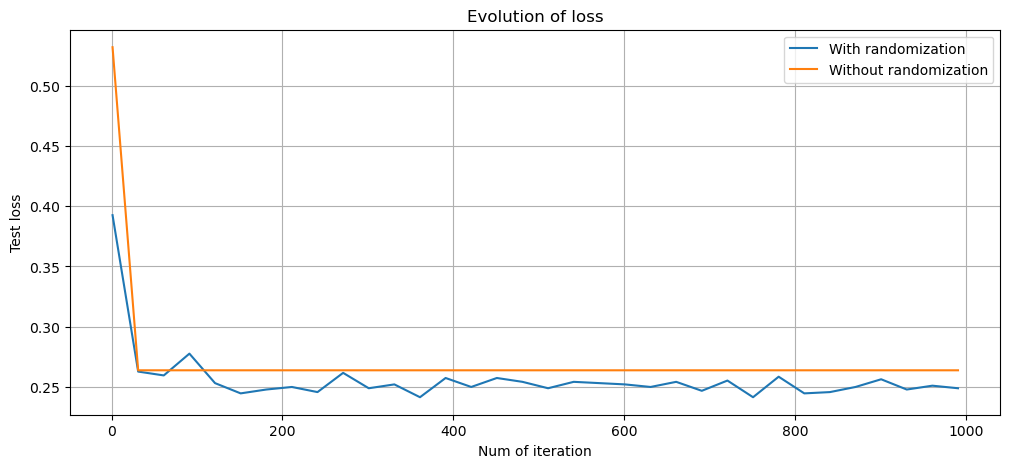

In [133]:
x = np.array( num_iterations )
plt.figure(figsize=(12,5))
plt.plot(x, losses_rand, label='With randomization')
plt.plot(x, losses_no_rand, label='Without randomization')
plt.title('Evolution of loss')
plt.xlabel('Num of iteration')
plt.ylabel('Test loss')
plt.legend()
plt.grid()

Generally, because of the randomness in the choice of the update, the randomized perceptron explores more possibilities and this results in the fact that it is able to find a smaller error than the deterministic counterpart